# FraudWatch – Data Audit, EDA e Preparação de Dados

Este notebook contempla a auditoria, a análise exploratória orientada à decisão e a preparação dos dados da POC FraudWatch, estabelecendo as bases técnicas para a modelagem e a avaliação temporal do sistema antifraude.

---
## Contexto

Fraudes em transações financeiras são eventos raros, porém de alto impacto operacional e financeiro.  
Esta POC utiliza dados públicos do Kaggle (dataset *Credit Card Fraud Detection*), tratados como um histórico real de transações para a construção do sistema FraudWatch.

Este notebook define a base técnica e operacional da POC, sendo responsável por auditar a qualidade dos dados, estabelecer regras de preparação e aplicar uma estratégia de divisão temporal que preserve a integridade do fluxo histórico.

> Para detalhes completos sobre as variáveis disponíveis, consulte o [Dicionário de Dados](references/01_dicionario_de_dados.md)

---

## Objetivo deste notebook

- Auditar a estrutura e a qualidade do dataset.
- Aplicar decisões explícitas de preparação e higienização dos dados.
- Definir e executar a divisão temporal dos dados.
- Garantir que os dados utilizados nas etapas subsequentes sejam auditáveis, versionados e replicáveis.

---

### Entregáveis

Ao final deste notebook, são gerados:

- Conjuntos de dados separados temporalmente:
  - `train`
  - `valid`
  - `test`
- Registro explícito das principais decisões de preparação, assegurando rastreabilidade técnica ao longo de toda a POC.

## 1. Inspeção inicial do dataset
Carregar a base e verificar estrutura, tipos e possíveis problemas antes da modelagem.

In [1]:
# Importação de bibliotecas

# 1. Standard library
import sys

sys.path.insert(0, "..")

# 2. Third-party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import EngFormatter
from scipy.stats import mannwhitneyu

# 3. Local (projeto)
from src.utils import save_split_metadata
from src.paths import (
    RAW_DATA,
    PROCESSED_SPLIT_METADATA,
    PROCESSED_TEST,
    PROCESSED_TRAIN,
    PROCESSED_VALID,
)

# 4. Configurações de display / plots
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)

sns.set_theme(style="whitegrid", context="notebook")

In [2]:
df = pd.read_csv(RAW_DATA, compression='zip')

display(df.head())

# Dimensões
print(f"Formato inicial do dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0


Formato inicial do dataset: 284807 linhas x 31 colunas


In [3]:
# Visão geral do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# Verificação e remoção de duplicados (linhas idênticas em todas as colunas)
n_before = len(df)
n_dups = int(df.duplicated().sum())

if n_dups > 0:
    df = df.drop_duplicates().reset_index(drop=True)

n_after = len(df)

print(f'Duplicados (linhas idênticas): {n_dups} | Removidos: {n_before - n_after} | Novo formato: {df.shape[0]} linhas x {df.shape[1]} colunas')

Duplicados (linhas idênticas): 1081 | Removidos: 1081 | Novo formato: 283726 linhas x 31 colunas


In [5]:
# Estatísticas operacionais
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,283726.0000,94811.0776,47481.0479,0.0000,54204.7500,84692.5000,139298.0000,172792.0000
V1,283726.0000,0.0059,1.9480,-56.4075,-0.9160,0.0204,1.3161,2.4549
V2,283726.0000,-0.0041,1.6467,-72.7157,-0.6003,0.0639,0.8003,22.0577
V3,283726.0000,0.0016,1.5087,-48.3256,-0.8897,0.1800,1.0270,9.3826
V4,283726.0000,-0.0030,1.4142,-5.6832,-0.8501,-0.0222,0.7396,16.8753
V5,283726.0000,0.0018,1.3770,-113.7433,-0.6898,-0.0535,0.6122,34.8017
V6,283726.0000,-0.0011,1.3319,-26.1605,-0.7690,-0.2752,0.3968,73.3016
V7,283726.0000,0.0018,1.2277,-43.5572,-0.5525,0.0409,0.5705,120.5895
V8,283726.0000,-0.0009,1.1791,-73.2167,-0.2088,0.0219,0.3257,20.0072
V9,283726.0000,-0.0016,1.0955,-13.4341,-0.6442,-0.0526,0.5960,15.5950


**Resumo da Inspeção Inicial**

Após o carregamento e a higienização, o dataset apresenta as seguintes características:

- **Dimensão após higienização**: 283.726 linhas × 31 colunas
- **Tipos de dados:**
    - Variáveis preditoras no formato `float`
    - Variável alvo `Class` no formato `int`, com valores:
        - `0` → transação legítima
        - `1` → transação fraudulenta
- **Valores ausentes:** nenhum valor ausente identificado
- **Registros duplicados:** 1.081 linhas completamente idênticas removidas

As variáveis `Time` e `Amount` possuem interpretação operacional direta, enquanto as colunas `V1–V28` correspondem a componentes resultantes de PCA, concentrando o principal sinal estatístico para a discriminação de fraudes.

## 2. Análise do Desbalanceamento

In [6]:
# Distribuição da variável alvo
class_counts = df["Class"].value_counts().sort_index()
class_counts

Class
0    283253
1       473
Name: count, dtype: int64

In [7]:
# Proporção de cada classe
class_ratio = df["Class"].value_counts(normalize=True).sort_index()
class_ratio

Class
0   0.9983
1   0.0017
Name: proportion, dtype: float64

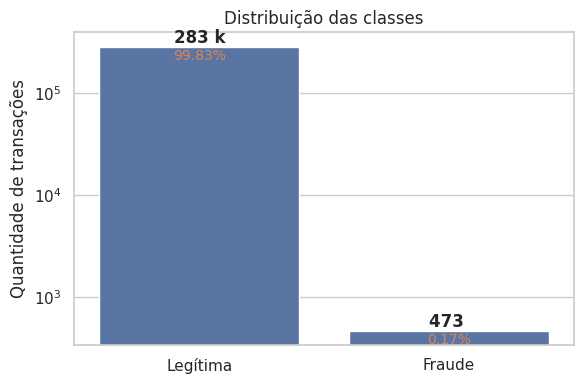

In [8]:
# Visualização da distribuição das classes (escala logarítmica)
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(data=df, x="Class", ax=ax)

# Substitui rótulos numéricos por texto
ax.set_xticks([0, 1])
ax.set_xticklabels(["Legítima", "Fraude"])

eng_fmt = EngFormatter(places=0)
ax.yaxis.set_major_formatter(eng_fmt)
ax.set_yscale("log")

# Garante ordem 0 -> 1
counts = df["Class"].value_counts().sort_index()
props = df["Class"].value_counts(normalize=True).sort_index()

# Labels (mesma ordem das barras: 0 depois 1)
ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=[eng_fmt.format_eng(v) for v in counts.values],
)

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    labels=[f"{v:.2%}" for v in props.values],
    padding=-12,
    fontsize=10,
    color='C1',
)

ax.set_title("Distribuição das classes")
ax.set_xlabel("")
ax.set_ylabel("Quantidade de transações")

plt.tight_layout()
plt.show()

**Análise do Desbalanceamento**

O conjunto de dados apresenta forte desbalanceamento entre transações legítimas e fraudulentas, característica típica de sistemas antifraude. A classe fraudulenta representa aproximadamente **0,17%** do total de registros.

Esse cenário torna inadequado o uso de métricas Ժ tradicionais como acurácia, demandando a adoção de métricas orientadas a eventos raros, em especial:

- recall de fraude;
- precision;
- PR-AUC.

> O nível de desbalanceamento observado influencia diretamente a definição das estratégias de modelagem, das políticas de decisão e dos thresholds operacionais adotados nas etapas subsequentes da FraudWatch.

## 3. Análise de Sinal Estatístico

### 3.1 Correlação com a Variável Alvo

In [9]:
corr_with_target = (
    df.corr(numeric_only=True)["Class"]
      .drop("Class")
      .sort_values(key=lambda x: x.abs(), ascending=False)
)

corr_with_target.head(10)

V17   -0.3135
V14   -0.2934
V12   -0.2507
V10   -0.2070
V16   -0.1872
V3    -0.1823
V7    -0.1723
V11    0.1491
V4     0.1293
V18   -0.1053
Name: Class, dtype: float64

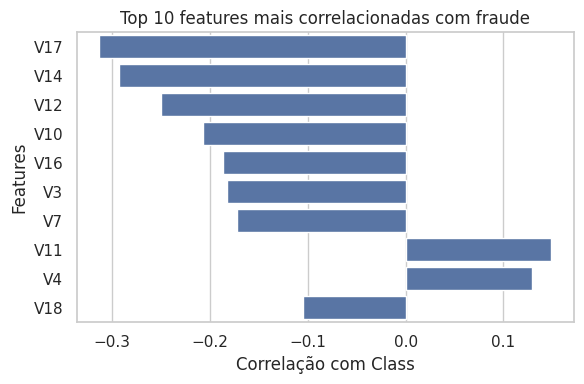

In [10]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(
    x=corr_with_target.head(10).values,
    y=corr_with_target.head(10).index
)

ax.set_title("Top 10 features mais correlacionadas com fraude")
ax.set_xlabel("Correlação com Class")
ax.set_ylabel("Features")

plt.tight_layout()
plt.show()

> A correlação com a variável alvo permite a identificação das features com maior associação linear ao evento de fraude. As maiores magnitudes de correlação concentram-se predominantemente nas componentes derivadas de PCA, enquanto as variáveis `Time` e `Amount` apresentam associação próxima de zero, indicando baixo poder discriminativo quando avaliadas de forma isolada.

### 3.2 Distribuição das Principais Features

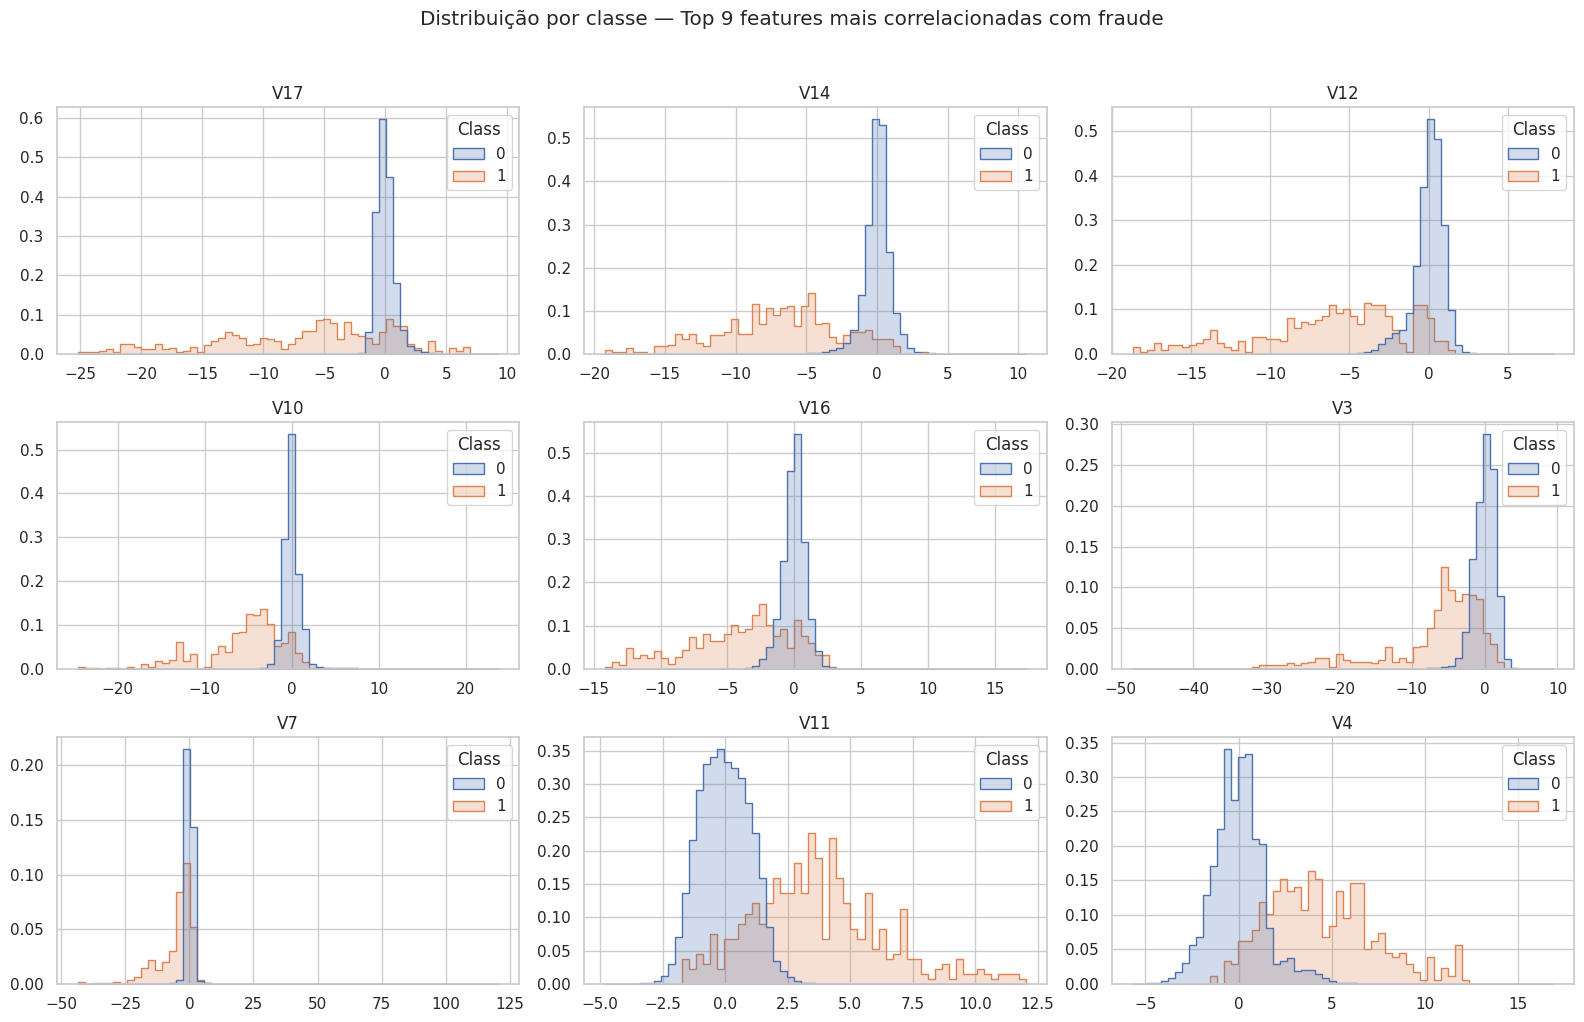

In [11]:
# Top 9 features por correlação absoluta com Class
top9 = corr_with_target.sort_values(key=lambda x: x.abs(), ascending=False).head(9).index.tolist()

fig, axs = plt.subplots(3, 3, figsize=(16, 10))
axs = axs.flatten()

for ax, feat in zip(axs, top9):
    sns.histplot(
        data=df,
        x=feat,
        hue="Class",
        bins=60,
        element="step",
        stat="density",
        common_norm=False,
        ax=ax
    )
    ax.set_title(feat)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Remove eixos extras (se houver)
for ax in axs[len(top9):]:
    ax.axis("off")

plt.suptitle("Distribuição por classe — Top 9 features mais correlacionadas com fraude", y=1.02)

plt.tight_layout()
plt.show()

> A análise das distribuições indica separação consistente entre transações legítimas e fraudulentas nas features mais correlacionadas, reforçando que o comportamento das fraudes se manifesta de forma distinta no espaço latente gerado pelo PCA.

### 3.3 Teste Estatístico de Mann-Whitney U

In [12]:
target = "Class"
alfa = 0.01

features = [c for c in df.columns if c != target]

df_legit = df[df[target] == 0]
df_fraud = df[df[target] == 1]

mw_results = []

for col in features:
    stat, pvalue = mannwhitneyu(
        df_legit[col],
        df_fraud[col],
        alternative="two-sided"
    )
    
    mw_results.append({
        "feature": col,
        "pvalue": pvalue,
        "estatistica": stat,
        "significativo": pvalue < alfa
    })

In [13]:
df_mw = (
    pd.DataFrame(mw_results)
      .sort_values("pvalue")
)

df_mw

,feature,pvalue,estatistica,significativo
14,V14,0.0000,126896444.0000,True
4,V4,0.0000,8540423.0000,True
12,V12,0.0000,125197232.0000,True
11,V11,0.0000,11411882.0000,True
10,V10,0.0000,121998541.0000,True
3,V3,0.0000,121738405.0000,True
2,V2,0.0000,20123145.0000,True
16,V16,0.0000,112734405.0000,True
9,V9,0.0000,112714371.0000,True
7,V7,0.0000,111151906.0000,True


> O teste de Mann-Whitney U avalia a existência de diferenças estatisticamente significativas entre as distribuições das features para transações legítimas e fraudulentas. A maioria das componentes PCA apresenta diferença significativa ao nível de significância adotado, enquanto um subconjunto reduzido de variáveis (por exemplo, `V13`, `V15`, `V22`, `V25`) não demonstra distinção estatística relevante.

### 3.4 Síntese Analítica

A análise de correlação e os testes estatísticos apontam para uma conclusão consistente: o sinal discriminativo de fraude concentra-se majoritariamente nas componentes `V1–V28`, enquanto as variáveis `Time` e `Amount` apresentam baixo poder preditivo quando avaliadas de forma isolada.

Com base nesses achados, são adotadas as seguintes decisões de preparação:

- As variáveis `V1–V28` constituem o núcleo preditivo do modelo.
- A variável `Amount` é mantida como feature auxiliar.
- A variável `Time` é utilizada exclusivamente como proxy temporal para a definição do split entre os conjuntos de treino, validação e teste.
- Não é aplicada remoção de outliers, uma vez que transações fraudulentas tendem a se manifestar como eventos extremos, e sua exclusão poderia degradar o desempenho do modelo.

## 4. Definição de Estratégia de Split Temporal

O conjunto de dados é tratado como um histórico sequencial de transações.
A separação entre treino, validação e teste é realizada de forma temporal, utilizando a variável `Time` como proxy de ordem cronológica.

Essa estratégia impede vazamento de informação do futuro para o passado e permite avaliar o modelo em um cenário compatível com a operação real de um sistema antifraude

In [14]:
# Ordenação temporal
df_sorted = df.sort_values("Time")

n = len(df_sorted)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

# Definição das janelas temporais
df_train = df_sorted.iloc[:train_end]
df_valid = df_sorted.iloc[train_end:valid_end]
df_test  = df_sorted.iloc[valid_end:]

len(df_train), len(df_valid), len(df_test)

(198608, 42559, 42559)

## 5. Criação dos Datasets Processados

As bases `train`, `valid` e `test` são construídas a partir do dataset ordenado por `Time`.  
Além do particionamento, são registradas as dimensões e a taxa de fraude em cada janela, permitindo a verificação de consistência mínima dos dados e servindo como referência para as etapas de modelagem e monitoramento.

In [15]:
summary_split = pd.DataFrame({
    "rows": {
        "train": len(df_train),
        "valid": len(df_valid),
        "test":  len(df_test),
    },
    "fraud_rate": {
        "train": df_train["Class"].mean(),
        "valid": df_valid["Class"].mean(),
        "test":  df_test["Class"].mean(),
    }
})

summary_split.style.format({"fraud_rate": "{:.4%}"})

,rows,fraud_rate
train,198608,0.1843%
valid,42559,0.1292%
test,42559,0.1222%


## 6. Exportação dos Artefatos

As bases particionadas são persistidas na camada [`data/processed/`](data/processed/) com o objetivo de garantir reprodutibilidade.  
Também são registrados metadados de cada janela, incluindo tamanho e intervalo temporal, permitindo a rastreabilidade de alterações no perfil dos dados ao longo das execuções.

In [16]:
# Exportação
df_train.to_parquet(PROCESSED_TRAIN, index=False)
df_valid.to_parquet(PROCESSED_VALID, index=False)
df_test.to_parquet(PROCESSED_TEST, index=False)

save_split_metadata(df_train, df_valid, df_test, PROCESSED_SPLIT_METADATA)

## Encerramento

Este notebook estabelece a base operacional da FraudWatch, contemplando:

- inspeção e higienização do dataset original;
- identificação do desbalanceamento extremo entre as classes;
- análise do sinal estatístico por meio de correlação e teste de Mann-Whitney;
- definição das variáveis preditivas centrais;
- particionamento temporal dos dados para mitigação de vazamento de informação;
- persistência dos artefatos processados, acompanhados de metadados.